In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=57a32bfd3e1bce44c35f625a72d51c79b7545904210623a88ecf2ec3182b97c0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


Using device: cpu


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 22.5MB/s]


Loaded pretrained weights for efficientnet-b0


<ipython-input-5-42c4c9577b4f>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # загрузка весов модели


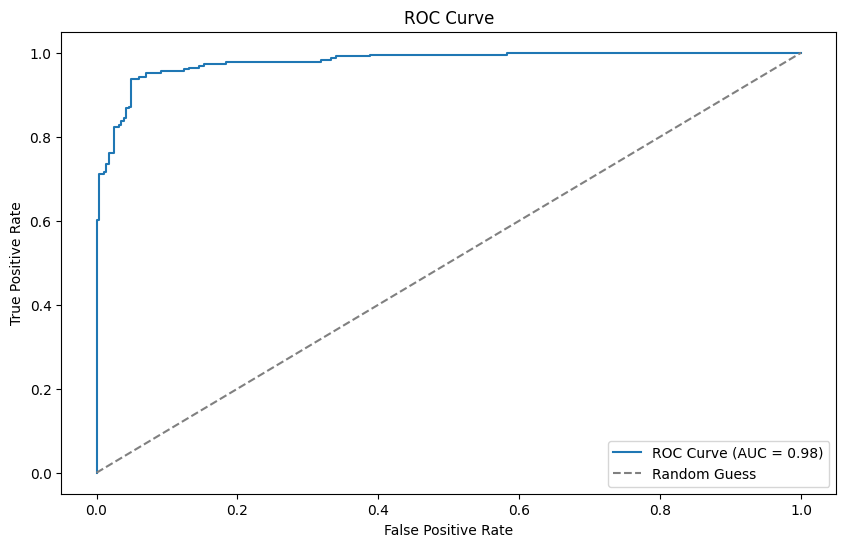

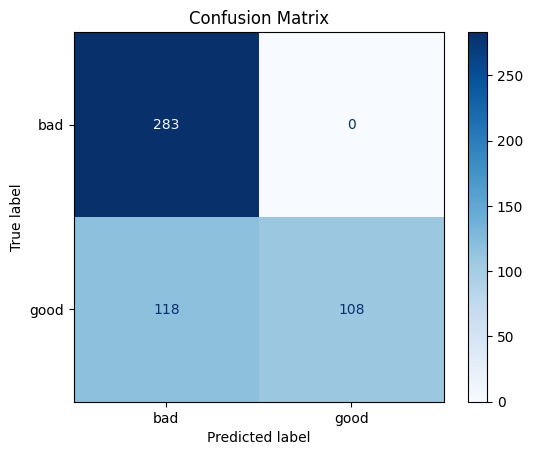

In [ ]:
import torch
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader

# параметры
model_path = "/content/drive/MyDrive/IBCh/SELF/untresh2/binary_classifier2.pth"  # путь к сохранённой модели
data_dir = "/content/drive/MyDrive/IBCh/SELF/untresh2/forROConly"  # путь к папке с размеченными фотографиями

# устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # выбор устройства для вычислений
print(f"Using device: {device}")

# подготовка данных
transform = transforms.Compose([
  transforms.Resize((224, 224)),  # размер изображений для EfficientNet
  transforms.ToTensor(),  # преобразование в тензор
  transforms.Normalize(mean=[0.5], std=[0.5])  # нормализация
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)  # загрузка размеченных данных
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)  # создание загрузчика данных

# загрузка модели
model = EfficientNet.from_pretrained('efficientnet-b0')  # загрузка предобученной модели EfficientNet
num_features = model._fc.in_features  # определение количества входных признаков последнего слоя
model._fc = torch.nn.Linear(num_features, 1)  # выходной слой для бинарной классификации
model.load_state_dict(torch.load(model_path, map_location=device))  # загрузка весов модели
model = model.to(device)  # перенос модели на выбранное устройство
model.eval()  # установка модели в режим оценки

# вычисление метрик
all_labels = []  # список для хранения истинных меток
all_outputs = []  # список для хранения предсказанных вероятностей
with torch.no_grad():  # отключение вычисления градиентов
  for images, labels in data_loader:  # итерация по загрузчику данных
    images = images.to(device)  # перенос изображений на устройство
    labels = labels.to(device).float()  # преобразование меток в формат float
    outputs = torch.sigmoid(model(images))  # вероятности предсказаний
    all_labels.extend(labels.cpu().numpy())  # добавление меток в список
    all_outputs.extend(outputs.cpu().numpy())  # добавление предсказаний в список

all_labels = np.array(all_labels)  # преобразование списка меток в массив
all_outputs = np.array(all_outputs)  # преобразование списка предсказаний в массив

# построение ROC-кривой
fpr, tpr, _ = roc_curve(all_labels, all_outputs)  # вычисление ROC-кривой
roc_auc = auc(fpr, tpr)  # вычисление площади под ROC-кривой

plt.figure(figsize=(10, 6))  # создание фигуры для графика
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")  # построение ROC-кривой
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")  # линия случайного угадывания
plt.xlabel("False Positive Rate")  # метка оси X
plt.ylabel("True Positive Rate")  # метка оси Y
plt.title("ROC Curve")  # заголовок графика
plt.legend()  # отображение легенды
plt.show()  # отображение графика

# матрица несоответствий
thresholded_predictions = (all_outputs > 0.5).astype(int)  # порог для классификации
conf_matrix = confusion_matrix(all_labels, thresholded_predictions)  # вычисление матрицы несоответствий

# визуализация матрицы несоответствий
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)  # настройка отображения
disp.plot(cmap="Blues")  # построение графика матрицы несоответствий
plt.title("Confusion Matrix")  # заголовок графика
plt.show()  # отображение графика


True Negative (TN): Верхний левый квадрат (283) — это количество правильно классифицированных примеров класса "bad".
False Positive (FP): Верхний правый квадрат (0) — это количество объектов класса "bad", ошибочно классифицированных как "good".
False Negative (FN): Нижний левый квадрат (118) — это количество объектов класса "good", ошибочно классифицированных как "bad".
True Positive (TP): Нижний правый квадрат (108) — это количество правильно классифицированных примеров класса "good".